# Module


In [1]:
import torch

In [2]:
import argparse
from torchsummary import summary
import tqdm
from tqdm import tqdm_notebook as tq
import os, time, math, copy
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from collections import namedtuple
import matplotlib.pyplot as plt

torch.set_printoptions(precision=8, linewidth=50000)
import warnings
warnings.filterwarnings(action='ignore')


# Print Colors

In [3]:
BLACK	= '\033[30m'
RED		= '\033[31m'
GREEN	= '\033[32m'
YELLOW	= '\033[33m'
BLUE	= '\033[34m'
MAGENTA	= '\033[35m'
CYAN	= '\033[36m'
RESET	= '\033[0m'
SEL		= '\033[7m'

# Fixed

In [4]:
class	fxp:
	def	__init__(self, bIn, iBWF):
		self.iFullBW	= len(bIn)
		self.iIntgBW	= self.iFullBW - iBWF
		self.bSign		= bIn[0]
		self.bIntg		= bIn[:self.iIntgBW]
		self.bFrac		= bIn[self.iIntgBW:]
		self.fFull		= 0
		try:
			for idx, bit in enumerate(bIn):
				if	idx == 0:
					self.fFull = self.fFull + int(bit,2) * -pow(2, self.iIntgBW - 1)
				else:
					self.fFull = self.fFull + int(bit,2) * pow(2, self.iIntgBW - 1 - idx)
		except:
			print(bIn)
		self.dispFull	= RED + self.bIntg + BLUE + self.bFrac + RESET
		return

In [5]:
class	flp2fix:
	def	__init__(self, fIn, iBW, iBWF):
		self.fMin		= - 2 ** (iBW - iBWF - 1)
		self.fMax		= (2 ** (iBW-1) - 1) * (2 ** -iBWF)
		self.fResol		= 2 ** -iBWF
		if fIn < self.fMin or fIn > self.fMax:
			print(f'({fIn}): Out of input range ({self.fMax}/{self.fMin}) during flp -> fix converting ')
		self.iBW		= iBW
		self.iBWI		= iBW - iBWF
		self.iBWF		= iBWF

		self.iFLP2INT	= abs(int(fIn * 2 ** iBWF))
		if fIn < 0:
			self.iFLP2INT = 2 ** (iBW-1) - self.iFLP2INT

		if fIn >= 0:
			self.bFull = bin(self.iFLP2INT)[2:].rjust(iBW, '0')
		else:
			self.bFull = '1'+bin(self.iFLP2INT)[2:].rjust(iBW-1, '0')
			if len(self.bFull) > iBW:
				self.bFull = '0' * iBW

		self.cssFxp		= fxp(self.bFull, self.iBWF)
		self.bSign		= self.cssFxp.bSign
		self.bIntg		= self.cssFxp.bIntg
		self.bFrac		= self.cssFxp.bFrac
		self.fFull		= self.cssFxp.fFull
		return

In [6]:
def	flp2fixTensor(fIn, iBW, iBWF):
	fMin = - 2 ** (iBW - iBWF - 1)
	fMax = (2 ** (iBW-1) - 1) * (2 ** -iBWF)
	fList = []
	for aTensor in fIn.view(-1):
		fList.append(flp2fix(aTensor, iBW, iBWF).fFull)
	return torch.tensor(fList).view(fIn.size())

# User Define Variable

In [7]:
data_path = '~/dataset'

# Parser

In [8]:
parser = argparse.ArgumentParser(description='PyTorch for MNIST dataset')
parser.add_argument('--device', type=str, default='cpu', help='Device')
parser.add_argument('--shuffle', action='store_true', default=False, help='enables data shuffle')
parser.add_argument('--dataset', type=str, default='mnist', help='training dataset')
parser.add_argument('--data_path', type=str, default=data_path, help='path to MNIST')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs to train')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--optimizer', type=str, default='adam', help='optimizer')
parser.add_argument('--loss_func', type=str, default='cel', help='optimizer')
parser.add_argument('--quant_opt', type=str, default='asym', help='Type of Quantization')
parser.add_argument('--full_bits', type=int, default=8, help='Number of Quantization Bits')
parser.add_argument('--frac_bits', type=int, default=3, help='Number of Quantization Bits')
parser.add_argument('--pretrained', type=bool, default=True, help='Pretrained Model')
parser.add_argument('--act_quant', type=bool, default=False, help='Activation Quantization')
parser.add_argument('--disp', type=bool, default=False, help='Display Model Information')

args = parser.parse_args(args=[])


# Preparing Data

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.device == 'cuda' else {}
transforms = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
if args.dataset == 'mnist':
	train_loader = torch.utils.data.DataLoader(
		dataset=datasets.MNIST(
			root=args.data_path,
			train=True,
			download=True,
			transform=transforms
		),
		batch_size=args.batch_size,
		shuffle=args.shuffle,
		**kwargs
	)

	test_loader = torch.utils.data.DataLoader(
		dataset=datasets.MNIST(
			root=args.data_path,
			train=False,
			download=True,
			transform=transforms
		),
		batch_size=args.batch_size,
		shuffle=args.shuffle,
		**kwargs
	)

# Build Model

In [10]:
class Lenet5(nn.Module):
    def __init__(self): #layer sequential define
        super(Lenet5, self).__init__()
        # 1 input image channel, 6 output channels, 5*5 square convolution
        self.flatten = nn.Flatten()
        self.Conv2d1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1)
        self.Conv2d2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1)
        self.Conv2d3 = nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1)
        self.AvgPool2d = nn.AvgPool2d(kernel_size = 2)
        self.ReLU = nn.ReLU()
        self.Linear1 = nn.Linear(120, 84)
        self.Linear2 = nn.Linear(84, 10)
    def forward(self, x) :
        x = self.Conv2d1(x)
        x = self.ReLU(x)
        x = self.AvgPool2d(x)
        x = self.Conv2d2(x)
        x = self.ReLU(x)
        x = self.AvgPool2d(x)
        x = self.Conv2d3(x)
        x = self.ReLU(x)
        x = torch.flatten(x, 1)
        x = self.Linear1(x)
        x = self.ReLU(x)
        x = self.Linear2(x)
        return x 

In [11]:
def genOptimizer(model, args):
	if args.optimizer == 'sgd':
		optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
	if args.optimizer == 'adam':
		optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
	return optimizer

In [12]:
def genLossFunc(args):
	if args.loss_func == 'cel':
		loss_func = nn.CrossEntropyLoss()
	return loss_func

In [13]:
def train(train_loader, model, epoch, args):
    model.train()
    loss_func = genLossFunc(args)
    optimizer = genOptimizer(model, args)
    max_batch_index = int(np.floor(len(train_loader.dataset)/args.batch_size)) #batch 번호 ..?
    running_loss,correct = 0, 0
    
    for batch_index, (image, label) in enumerate(tq(train_loader, desc='Train', leave=False)):
        image, label = image.to(args.device), label.to(args.device)
        pred = model(image) #pred = model
        loss = loss_func(pred, label) # model 이용해서 loss 구함)
        running_loss += loss.item()#*image.size(0)
        correct += (pred.argmax(1) == label).type(torch.int).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    final_loss = running_loss/len(train_loader.dataset)
    correct_rate = 100 * correct / len(train_loader.dataset)
    print(f'Epoch {epoch+1:<3d}: Avg. Loss: {final_loss:.4f}', end = '\t')
    print(f'Accuracy: {correct}/{len(train_loader.dataset)} ({correct_rate:>.1f}%)')
    
    return final_loss,correct_rate

In [14]:
def test(test_loader, model, args):
    model.eval()
    with torch.no_grad():
        loss_func = genLossFunc(args)
        loss, correct = 0, 0
# for batch_index, (image, label) in enumerate(tq(test_loader, desc='Test', leave=False)):
        for batch_index, (image, label) in enumerate(test_loader):
            image, label = image.to(args.device), label.to(args.device)
            pred = model(image)
            loss += loss_func(pred, label).item()#*image.size(0)
            correct += (pred.argmax(1) == label).type(torch.int).sum().item()
    loss /= len(test_loader.dataset)
    correct_rate = 100 * correct / len(test_loader.dataset)
    print(f'Accuracy: {correct}/{len(test_loader.dataset)} ({correct_rate:>.1f}%)')
    return loss,correct_rate

In [15]:
def main(model):
    train_loss_hist = []
    train_acc_hist = []
    eval_loss_hist = []
    eval_acc_hist = []
    for epoch in range(args.epochs):
        train_loss,train_acc = train(train_loader, model, epoch, args)
        eval_loss,eval_acc = test(test_loader, model, args)
        train_loss_hist.append(train_loss)
        eval_loss_hist.append(eval_loss)
        train_acc_hist.append(train_acc)
        eval_acc_hist.append(eval_acc)
    print("Done!")
    return model,train_loss_hist,train_acc_hist,eval_loss_hist,eval_acc_hist

In [16]:
model,train_loss_hist,train_acc_hist,eval_loss_hist,eval_acc_hist = main(Lenet5().to(args.device))
torch.save(model.state_dict(), 'PTQ.pth')

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1  : Avg. Loss: 0.0057	Accuracy: 53462/60000 (89.1%)
Accuracy: 9540/10000 (95.4%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2  : Avg. Loss: 0.0017	Accuracy: 58043/60000 (96.7%)
Accuracy: 9736/10000 (97.4%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3  : Avg. Loss: 0.0011	Accuracy: 58674/60000 (97.8%)
Accuracy: 9781/10000 (97.8%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4  : Avg. Loss: 0.0008	Accuracy: 59007/60000 (98.3%)
Accuracy: 9811/10000 (98.1%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5  : Avg. Loss: 0.0007	Accuracy: 59263/60000 (98.8%)
Accuracy: 9843/10000 (98.4%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6  : Avg. Loss: 0.0005	Accuracy: 59401/60000 (99.0%)
Accuracy: 9866/10000 (98.7%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7  : Avg. Loss: 0.0004	Accuracy: 59514/60000 (99.2%)
Accuracy: 9863/10000 (98.6%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8  : Avg. Loss: 0.0004	Accuracy: 59610/60000 (99.3%)
Accuracy: 9848/10000 (98.5%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9  : Avg. Loss: 0.0003	Accuracy: 59649/60000 (99.4%)
Accuracy: 9873/10000 (98.7%)


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10 : Avg. Loss: 0.0003	Accuracy: 59694/60000 (99.5%)
Accuracy: 9869/10000 (98.7%)
Done!


In [17]:
print(model)

Lenet5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Conv2d1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Conv2d2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Conv2d3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (AvgPool2d): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (ReLU): ReLU()
  (Linear1): Linear(in_features=120, out_features=84, bias=True)
  (Linear2): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
summary(model,input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              ReLU-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [19]:
def model2fix(model, args):
	for name, _ in model.named_parameters():
		exec(f'model.{name}.data = flp2fixTensor(model.{name}.data, {args.full_bits}, {args.frac_bits})')
	return model

In [20]:
def quantFixForward(model, x, args):
    cmodel = copy.deepcopy(model).to(args.device)
    with torch.no_grad():
        act0 = cmodel.AvgPool2d(cmodel.ReLU(cmodel.Conv2d1(x))) #activation
        act0 = flp2fixTensor(act0, args.full_bits, args.frac_bits)

        act1 = cmodel.AvgPool2d(cmodel.ReLU(cmodel.Conv2d2(act0)))
        act1 = flp2fixTensor(act1, args.full_bits, args.frac_bits)

        act2 = cmodel.ReLU(cmodel.Conv2d3(act1))
        act2 = flp2fixTensor(act2, args.full_bits, args.frac_bits)

        act3 = cmodel.flatten(act2)
        act3 = flp2fixTensor(act3, args.full_bits, args.frac_bits)
        
        act4 = cmodel.ReLU(cmodel.Linear1(act3))
        act4 = flp2fixTensor(act4, args.full_bits, args.frac_bits)
        
        act5 = cmodel.Linear2(act4)
        act5 = flp2fixTensor(act5, args.full_bits, args.frac_bits)

    return cmodel, act0, act1, act2, act3, act4, act5

In [21]:
def testQuant(model, test_loader,args):
    qmodel = copy.deepcopy(model).to(args.device)
    qmodel = model2fix(qmodel, args)
    qmodel.eval()
    
    with torch.no_grad():
        loss_func = genLossFunc(args)
        loss, correct = 0, 0
        for batch_index, (image, label) in enumerate(tq(test_loader,desc='Train', leave=False)):
            image, label = image.to(args.device), label.to(args.device)
            qmodel, act0, act1, act2, act3, act4, act5  = quantFixForward(qmodel, image, args)
            y = act5
            loss += loss_func(y, label).item()#*image.size(0)
            correct += (y.argmax(1) == label).type(torch.int).sum().item()
    correct_rate = 100 * correct / len(test_loader.dataset)
    print(f'Accuracy: {correct}/{len(test_loader.dataset)} ({correct_rate:>.1f}%) Loss: {loss/len(test_loader.dataset):.2f}')
    return qmodel, act0, act1, act2, act3, act4, act5

In [22]:
qmodel, act0, act1, act2, act3, act4, act5= testQuant(model,test_loader,args)

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy: 9319/10000 (93.2%) Loss: 0.02


# graph

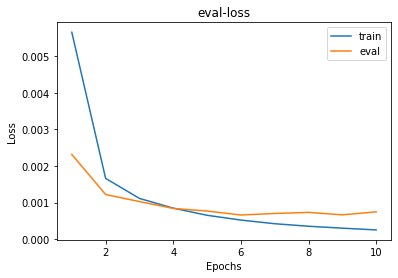

In [23]:
plt.title("eval-loss")

plt.plot(range(1,args.epochs+1),train_loss_hist,label="train")
plt.plot(range(1,args.epochs+1),eval_loss_hist,label="eval")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

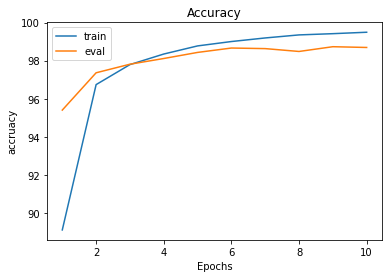

In [24]:
plt.title("Accuracy")

plt.plot(range(1,args.epochs+1),train_acc_hist,label="train")
plt.plot(range(1,args.epochs+1),eval_acc_hist,label="eval")
plt.ylabel("accruacy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# GenVector

In [25]:
def extractParams(model, args):
    for key in model.state_dict().keys():
        layer_name = key.split('.')[0]
        param_type = 'w' if 'weight' in key else 'b'
        for idx, params in enumerate(eval(f'qmodel.{key}.data')):
            with open(f'mif/{layer_name}_{param_type}_{idx}.mif', 'w') as fh:
                if param_type == 'w':
                    if params.dim() == 1 :
                        #print(f'param dim is {params.dim()}')
                        for idx, param in enumerate(params):
                            bin_param = flp2fix(param, args.full_bits, args.frac_bits).bFull
                            fh.write(bin_param + ('\n','')[idx == len(params)-1])
                    elif params.dim() == 3 :
                        #print(f'param dim is {params.dim()}')
                        for idx, dim1 in enumerate(params):
                            for idx, dim2 in enumerate(dim1):
                                for idx, param in enumerate(dim2) :
                                    bin_param = flp2fix(param, args.full_bits, args.frac_bits).bFull
                                    fh.write(bin_param + ('\n','')[idx == len(params)-1])
                else:
                    bin_param = flp2fix(params, args.full_bits, args.frac_bits).bFull
                    fh.write(bin_param)

In [26]:
def genInputVector(test_loader, args):
    out_path = './vec'
    os.system(f'rm -rf {out_path};mkdir -p {out_path}')
    with open(f'{out_path}/labels.vec', 'w') as fh_labels:
        with open(f'{out_path}/images.vec', 'w') as fh_images:
            for batch_index, (images, labels) in enumerate(test_loader):
                for (image, label) in zip(images, labels):
                    bin_label = flp2fix(label, args.full_bits, 0).bFull
                    fh_labels.write(bin_label+'\n')
                    for pixel in image.view(-1):
                        bin_pixel = flp2fix(pixel, args.full_bits, args.frac_bits).bFull
                        fh_images.write(bin_pixel+'\n')

In [27]:
#if not args.pretrained:
extractParams(model, args)

In [28]:
genInputVector(test_loader, args)

In [29]:
test_data = datasets.MNIST(	root=args.data_path,
							train=False,
							download=True,
							transform=transforms)

In [30]:
for batch_index, (image, label) in enumerate(test_loader):
           image, label = image.to(args.device), label.to(args.device)

In [31]:
len(test_loader)

157

In [32]:
image.size()

torch.Size([16, 1, 32, 32])

In [33]:
test_iter = iter(test_loader)

In [34]:
a_input = image
a_input.size()

torch.Size([16, 1, 32, 32])

# Check

### conv

In [35]:
def conv(X, filters,bias, stride=1, pad=0):
    n, c, h, w = X.shape # 1, 1, 32, 32
    n_f, _, filter_h, filter_w = filters.shape
    
    out_h = (h+2*pad-filter_h)//stride + 1
    out_w = (w+2*pad-filter_w)//stride + 1
    # add padding to height and width.
    in_X = F.pad(X,(0,0,0,0,pad,pad,pad,pad),"constant", 0)
    out  = torch.zeros((n, n_f, out_h, out_w))
    
    for i in range(n): # for each image.
        for c in range(n_f): # for each channel.
            for h in range(out_h): # slide the filter vertically.
                h_start = h * stride
                h_end = h_start + filter_h
                for w in range(out_w): # slide the filter horizontally.
                    w_start = w * stride
                    w_end = w_start + filter_w
                    # Element-wise multiplication.
                    out[i, c, h, w] = torch.sum(in_X[i,:,h_start:h_end,w_start:w_end]*filters[c])+bias[c]
    
    return out

### ReLU_4D

In [36]:
def ReLU_4D(X):
    n, c, h, w = X.shape
    
    out = torch.zeros(n,c,h,w)
    
    for i in range(n): #for each image
        for ch in range(c) : #for each channel
            for o_h in range(h) : #for each height
                for o_w in range(w) : #for each width
                    x = X[i, ch, o_h, o_w]
                    if x > 0 :
                        out[i, ch, o_h, o_w] = x
                    else :
                        out[i, ch, o_h, o_w] = 0
    
    return out

### ReLU_2D

In [37]:
def ReLU_2D(X):
    n, c = X.shape
    
    out = torch.zeros(n,c)
    
    for i in range(n): #for each image
        for ch in range(c) : #for each channel
                    x = X[i, ch]
                    if x > 0 :
                        out[i, ch ] = x
                    else :
                        out[i, ch ] = 0
    return out

### avgpool

In [38]:
def avgpool2d(X,kernel_size,stride,pad=0):
    n, c, h, w = X.shape
    ker_w, ker_h = kernel_size
    
    out_h = (h + 2*pad - ker_h)//stride + 1
    out_w = (w + 2*pad - ker_w)//stride + 1
    
    out = torch.zeros(n,c,out_h,out_w)
    for i in range(n) : #for each image
        for ch in range(c) : #for each channel 
             for h in range(out_h) :
                    h_start = h * stride
                    h_end = h_start + ker_w
                    for w in range(out_w):
                        w_start = w * stride
                        w_end = w_start + ker_w
                        #element average
                        out[i, ch, h, w] = torch.mean(X[i,ch,h_start:h_end,w_start:w_end])
    
    return out

### linear

## checking

In [39]:
filters1 = qmodel.Conv2d1.weight
filters2 = qmodel.Conv2d2.weight
filters3 = qmodel.Conv2d3.weight

In [40]:
bias1 = qmodel.Conv2d1.bias
bias2 = qmodel.Conv2d2.bias
bias3 = qmodel.Conv2d3.bias

In [41]:
linear_filter1 = qmodel.Linear1.weight
linear_filter2 = qmodel.Linear2.weight

In [42]:
linear_bias1 = qmodel.Linear1.bias
linear_bias2 = qmodel.Linear2.bias

In [43]:
linear_filter1.shape

torch.Size([84, 120])

In [44]:
linear_filter2.shape

torch.Size([10, 84])

### act0

In [45]:
layer_conv1 = conv(a_input,filters1,bias1,stride=1,pad=0)

In [46]:
layer_ReLU1 = ReLU_4D(layer_conv1)

In [47]:
layer_avgpool1 = avgpool2d(layer_ReLU1,(2,2),2,pad=0)

In [48]:
layer_avgpool1.shape

torch.Size([16, 6, 14, 14])

In [49]:
act0.shape

torch.Size([16, 6, 14, 14])

In [50]:
fix_act0 = torch.zeros(16,6,14,14)

total = 0
num = 0

for a in range(16) :
    for b in range(6) :
        for c in range(14) :
            for d in range(14) :
                fix_act0[a][b][c][d] = flp2fix(layer_avgpool1[a][b][c][d],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act0[a][b][c][d],act0[a][b][c][d])==False):
                    num += 1
                #bin_conv1[a][b][c][d] = flp2fix(fix_conv1[a][b][c][d],args.full_bits,args.frac_bits).bFull
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 1/18816


In [51]:
torch.equal(fix_act0,act0)

False

### act1

In [52]:
layer_conv2 = conv(fix_act0,filters2,bias2,stride=1,pad=0)

In [53]:
layer_ReLU2 = ReLU_4D(layer_conv2)

In [54]:
layer_avgpool2 = avgpool2d(layer_ReLU2,(2,2),2,pad=0)

In [55]:
layer_avgpool2.shape

torch.Size([16, 16, 5, 5])

In [56]:
act1.shape

torch.Size([16, 16, 5, 5])

In [57]:
fix_act1 = torch.zeros(16,16,5,5)

total = 0
num = 0

for a in range(16) :
    for b in range(16) :
        for c in range(5) :
            for d in range(5) :
                fix_act1[a][b][c][d] = flp2fix(layer_avgpool2[a][b][c][d],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act1[a][b][c][d],act1[a][b][c][d])==False):
                    num += 1
                    print(fix_act1[a][b][c][d].item())
                    print(act1[a][b][c][d].item())
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/6400


In [58]:
torch.equal(fix_act1,act1)

True

In [59]:
qmodel_layer_conv2 = qmodel.Conv2d2(fix_act0)

In [60]:
torch.equal(layer_conv2,qmodel_layer_conv2)

True

In [61]:
qmodel_layer_ReLU2 = qmodel.ReLU(qmodel_layer_conv2)

In [62]:
torch.equal(layer_ReLU2,qmodel_layer_ReLU2)

True

In [63]:
total = 0
num = 0

for a in range(16) :
    for b in range(16) :
        for c in range(10) :
            for d in range(10) :
                if (torch.equal(layer_ReLU2[a][b][c][d],qmodel_layer_ReLU2[a][b][c][d])==False):
                    num += 1
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/25600


In [64]:
qmodel_layer_avgpool2 = qmodel.AvgPool2d(qmodel_layer_ReLU2)

In [65]:
qmodel_fix_act1 = torch.zeros(16,16,5,5)

In [66]:
total = 0
num = 0

for a in range(16) :
    for b in range(16) :
        for c in range(5) :
            for d in range(5) :
                qmodel_fix_act1[a][b][c][d] = flp2fix(qmodel_layer_avgpool2[a][b][c][d],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act1[a][b][c][d],qmodel_fix_act1[a][b][c][d])==False):
                    num += 1                
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/6400


### act2

In [67]:
layer_conv3 = conv(fix_act1,filters3,bias3,stride=1,pad=0)

In [68]:
layer_ReLU3 = ReLU_4D(layer_conv3)

In [69]:
act2.shape

torch.Size([16, 120, 1, 1])

In [70]:
fix_act2 = torch.zeros(16,120,1,1)

total = 0
num = 0

for a in range(16) :
    for b in range(120) :
        for c in range(1) :
            for d in range(1) :
                fix_act2[a][b][c][d] = flp2fix(layer_ReLU3[a][b][c][d],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act2[a][b][c][d],act2[a][b][c][d])==False):
                    num += 1
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/1920


In [71]:
qmodel_layer_conv3 = qmodel.Conv2d3(fix_act1)

In [72]:
torch.equal(layer_conv3,qmodel_layer_conv3)

True

### flatten

In [73]:
fix_act2.shape

torch.Size([16, 120, 1, 1])

In [74]:
layer_act3 = fix_act2.view(16,120)

In [75]:
layer_act3.shape

torch.Size([16, 120])

In [76]:
fix_act3 = torch.zeros(16,120)

total = 0
num = 0

for a in range(16) :
    for b in range(120) :
                fix_act3[a][b] = flp2fix(layer_act3[a][b],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act3[a][b],act3[a][b])==False):
                    num += 1
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/1920


### fc1

In [77]:
layer_fc1 = torch.matmul(fix_act3,linear_filter1.t()) + linear_bias1

In [78]:
layer_fc1.shape

torch.Size([16, 84])

In [79]:
layer_fc_ReLU1 = ReLU_2D(layer_fc1)

In [80]:
fix_act4 = torch.zeros(16,84)

total = 0
num = 0

for a in range(16) :
    for b in range(84) :
                fix_act4[a][b] = flp2fix(layer_fc_ReLU1[a][b],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act4[a][b],act4[a][b])==False):
                    num += 1
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/1344


### fc2

In [81]:
layer_fc2 = torch.matmul(fix_act4,linear_filter2.t()) + linear_bias2

In [82]:
layer_fc2.shape

torch.Size([16, 10])

In [83]:

fix_act5 = torch.zeros(16,10)

total = 0
num = 0

for a in range(16) :
    for b in range(10) :
                fix_act5[a][b] = flp2fix(layer_fc2[a][b],args.full_bits,args.frac_bits).fFull
                if (torch.equal(fix_act5[a][b],act5[a][b])==False):
                    num += 1
                total += 1

print("number of different value is : {num}/{total}".format(num=num,total=total))

number of different value is : 0/160
